In [1]:
import numpy as np
from qiskit.tools.jupyter import *
from qiskit import IBMQ
# ibm account manager
#   - communicate with online account 
#       - store/delete
#       - enable/disenable
#   - communicate with ibmq online devices, quantum computers
#       - get actual quantum computers as backend

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.ibmq.get_provider(hub='ibm-q', group='open', project='main')

In [4]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [5]:
backend = provider.get_backend('ibmq_bogota')
back_config = backend.configuration()

In [6]:
print("number of qubit: ", back_config.n_qubits)
print("support open pulse?: ", back_config.open_pulse)
print("basic gate set: ", back_config.basis_gates)

number of qubit:  5
support open pulse?:  True
basic gate set:  ['id', 'rz', 'sx', 'x', 'cx', 'reset']


In [7]:
dt = back_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


backend defaults contains approximated specs for the quantum computer that can be a good start point for our following experiment to find more accurate frequency.

In [8]:
back_defualt = backend.defaults()

In [9]:
# frequncies for all the 5 qubits
back_defualt.qubit_freq_est

[5000438508.808786,
 4849869600.505476,
 4782947922.824077,
 4858102479.657258,
 4978359406.878603]

Define basic parameter and constants

In [10]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz

us = 1.0e-6 # Microsecond
ns = 1.0e-9 # Nanosecond

# the index of the qubit in backend that we want to find frequency with
qubitIdx = 4

mem_slot = 0

In [11]:
# define the search range and get a list of frequencies
center_f_Hz = back_defualt.qubit_freq_est[qubitIdx]

f_span = 50 * MHz
f_step = 1 * MHz

f_min = center_f_Hz - f_span/2
f_max = center_f_Hz + f_span/2

frequencies_GHz = np.arange(f_min/GHz, f_max/GHz, f_step/GHz)

print(f"We'll measure the {qubitIdx}th qubit in {back_config.backend_name} \n")
print(f"sweep from {frequencies_GHz[0]} GHz to {frequencies_GHz[-1]} GHz with approximated frequncy {center_f_Hz/GHz} GHz")

We'll measure the 4th qubit in ibmq_bogota 

sweep from 4.953359406878603 GHz to 5.003359406878619 GHz with approximated frequncy 4.978359406878603 GHz


In [12]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [14]:
from qiskit import pulse
from qiskit.circuit import  Parameter

drive_sigma_sec = 0.075 * us
drive_duration_sec = 8 * drive_sigma_sec

drive_amp =0.05
freq = Parameter('freq')

with pulse.build(backend=backend, default_alignment='sequential', name='freq_sweep') as sweep_plan:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubitIdx)

    pulse.set_frequency(freq, drive_chan)
    pulse.play(pulse.Gaussian(
        duration=drive_duration,
        sigma=drive_sigma,
        amp=drive_amp,
        name='freq_sweep_excitation_pulse'
    ),channel=drive_chan)
    pulse.measure(qubits=[qubitIdx], registers=[pulse.MemorySlot(mem_slot)])

frequencies_Hz = frequencies_GHz * GHz
schedules = [sweep_plan.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

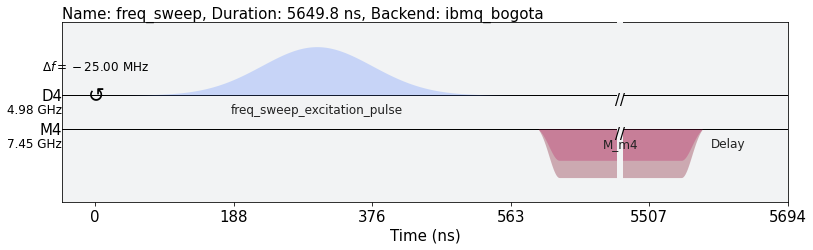

In [15]:
schedules[0].draw(backend=backend)